In [1]:
# imports from predefined functions
from database_pulls import query_reader
from sentiment_analysis import vader_analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from text_library import Textastic 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# old query with comments, leaving out to see if affects runtime
query_location = """
SELECT listing_id, latitude, longitude, comments, REPLACE(price, '$', '') as price, neighbourhood_cleansed
FROM reviews JOIN listings ON reviews.listing_id = listings.id;
"""

In [3]:
database = 'airbnb2.db'

query_location = """
SELECT listing_id, latitude, longitude, comments, REPLACE(price, '$', '') as price, neighbourhood_cleansed
FROM reviews JOIN listings ON reviews.listing_id = listings.id;
"""

# Creates / filters Dataframe, finds sentiment score /// This takes some time
df_location = query_reader(query_location, database)
df_location['scores'] = df_location['comments'].apply(vader_analysis)
df_location['price'] = df_location['price'].str.replace(',', '', regex=True).astype(float)

# This filters out the exact zero scores, which aren't processed
df_loc = df_location[df_location['scores'] != 0 ]

In [4]:
# Filter host-names column from Dataframe into stopwords to remove host names

In [5]:
# One big string glob of ALL the reviews for a particular unit?
# Write to a text file and then do Textastic analysis on the highest rated ones
# Concatenate ALL of the reviews into one. Will this work? I do not care. 

In [6]:
# Do more active Airbnb Hosts get consistenly higher reviews?
query = """SELECT listing_id, COUNT(*) as num_reviews
FROM reviews
GROUP BY listing_id
ORDER BY num_reviews DESC;"""
df_listing = query_reader(query, database)

In [7]:
df_listing.head()

,listing_id,num_reviews
0,4090224,821
1,815639,761
2,18290558,758
3,916123,750
4,18584891,691


In [8]:
# I'd like to extract the comments of the K best rated Airbnbs, analyze them, and then do other stuff
# This should increase performance since we're only doing VADER analysis on K * n samples instead of 160k
# This should probably be faster
# Going to describe what I want to do in plain English because I do not want to write code right now

In [9]:
# Plan for Friday / Saturday / Sunday
# How to finish a project in 4 days

# 1. Select the K top most rated listings. Min_reviews parameter optional. Probably with some join.
# 2. Extract the comments and squish together into one large string
# 3. Save those strings as K different text files 
# 4. Run it through Textastic framework for Sankey visualization
# 5. Iteratively modify stopwords file to remove common jargon
# 6. Hopefully have a decently good-looking deliverable
# 7. Formulate policy recommendations based on Sankey results
# 8. Apply statistical analysis techniques to build out a model
# 9. Create some interesting visualizations
# 10. Profit. 

In [10]:
# Each listing has it's own set of comments, sankey a listing as source and a combined text file as the targets?

In [11]:
df_location2 = df_loc.groupby('listing_id').agg({'price': 'mean', 'scores': 'mean'}).reset_index()
unranked_scores = df_location2.sort_values(by='listing_id', ascending=False)

In [12]:
unranked_scores.head()

,listing_id,price,scores
2713,841300163917010243,318.0,0.475400
2712,837676098532127827,184.0,0.673433
2711,837665944621160923,137.0,0.797900
2710,837538755134178518,172.0,0.475400
2709,835104074261525866,65.0,0.726300


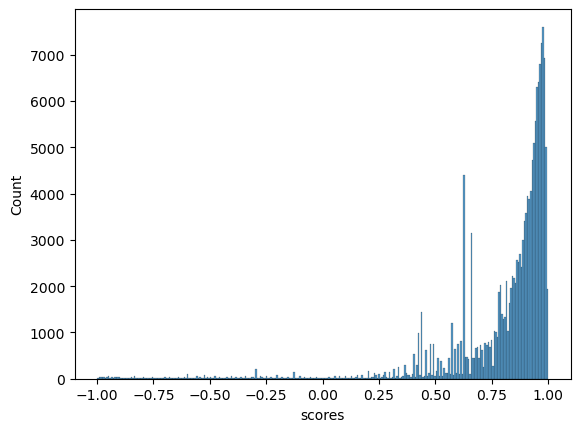

In [13]:
# Plots distribution of scores after removing zeros
sns.histplot(df_loc.scores)
plt.show()

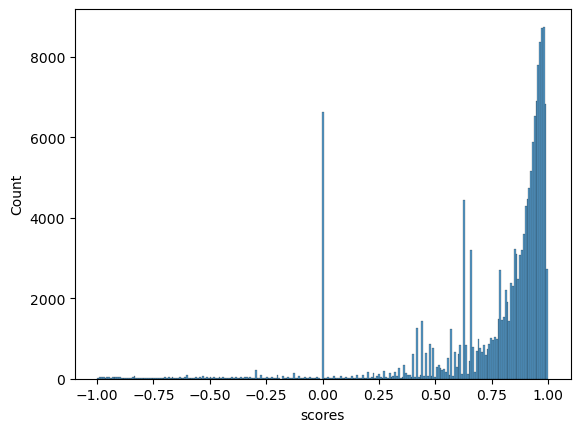

In [14]:
# Plots distribution of scores WITHOUT removing zeros
sns.histplot(df_location.scores)
plt.show()

In [15]:
def review_combiner(listing_id):
    """Given listing_id, creates a text blob of all their reviews"""
    
    # Create key value pair
    review_dict = {}

    # Creates list of comments with desired id and empty string
    comments = (df_location[df_location['listing_id']==listing_id])['comments']
    string = ""

    # Concatenates comments to one string
    for comment in comments:
        string += comment 
        
    return string


In [16]:
unranked_scores['text_blob'] = unranked_scores['listing_id'].apply(review_combiner)
df_ranked = unranked_scores.sort_values(by='listing_id')
df_listing2 = df_listing.sort_values(by='listing_id')

In [17]:
# Creates merged DataFrame 
df_merge = pd.merge(df_ranked, df_listing2, on='listing_id')
df_merge.head()

,listing_id,price,scores,text_blob,num_reviews
0,3781,132.0,0.902479,The apartment was as advertised and Frank was ...,24
1,5506,149.0,0.849666,Terry's Hotel Alterntv in Boston was a perfect...,118
2,6695,179.0,0.861175,Terry's apartment is beautifully decorated and...,123
3,8789,90.0,0.864846,Great accommodations for the price and nearby ...,25
4,10813,120.0,0.798325,The host canceled this reservation the day bef...,5


In [18]:
# Adds neighborhood to df_merge
id_town_dict = {}

for i, listing_id in enumerate(df_loc['listing_id'].values):
    id_town_dict[listing_id] = df_loc['neighbourhood_cleansed'].values[i]

df_merge['neighborhood'] = id_town_dict.values()
df_merge.head()

,listing_id,price,scores,text_blob,num_reviews,neighborhood
0,3781,132.0,0.902479,The apartment was as advertised and Frank was ...,24,East Boston
1,5506,149.0,0.849666,Terry's Hotel Alterntv in Boston was a perfect...,118,Roxbury
2,6695,179.0,0.861175,Terry's apartment is beautifully decorated and...,123,Dorchester
3,8789,90.0,0.864846,Great accommodations for the price and nearby ...,25,South End
4,10813,120.0,0.798325,The host canceled this reservation the day bef...,5,Roxbury


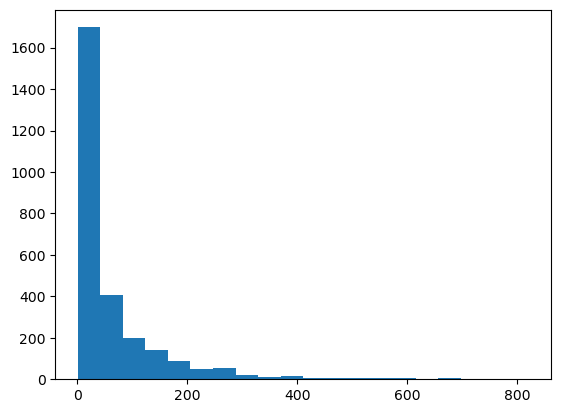

In [19]:
# Visualizing distribution of number of reviews
plt.hist(df_merge.num_reviews, bins=20)
plt.show()

In [20]:
drop = widgets.Dropdown(
    options=df_merge['neighborhood'].unique(),
    value='South End',
    description='Neighborhood:',
    disabled=False,
)

In [21]:
k = widgets.IntSlider(
    value=5,
    min=1,
    max=10,
    step=1,
    description="Listings",
    orientation='vertical'
)

In [22]:
min_reviews = widgets.IntSlider(
    value=50,
    min=10,
    max=500,
    step=10,
    description='Minimum Reviews'
)

In [23]:
def limit_sort(neighborhood=drop, k=5, min_reviews=100, ascending=False):
    """ Selects K most highly rated properties from given neighborhood given min_reviews"""
    
    place = df_merge[df_merge['num_reviews']>=min_reviews]
    place = place[place['neighborhood']==neighborhood]
    place = place.sort_values(by='scores', ascending=ascending)
    if len(place) < k:
        
        return place
    
    elif len(place) >= k:
        return place[:k]

In [27]:
# Stopwords read in manually
### Stopwords can be manually added to the set of words to remove
df_words = pd.read_csv('combined.csv')
Textastic.stop_words = set(df_words['name'].values)
Textastic.stop_words.add('')
Textastic.stop_words.add('home')
Textastic.stop_words.add('room')

In [29]:
@interact(neighborhood=drop, k=k, min_reviews=min_reviews)
def plot_sankey(neighborhood, k, min_reviews):
    
    # Creates instance of text library object
    tt = Textastic()
    df = limit_sort(neighborhood, k, min_reviews)
    for i, text_blob in enumerate(df['text_blob'].values):
        filename = 'sample'+f'{i}'+'.txt'

        f = open(filename, 'w')
        f.write(text_blob)
        tt.load_text(filename, label=f'#{i+1} Best Rental')
        f.close()
        
    tt.make_sankey(k=5)



interactive(children=(Dropdown(description='Neighborhood:', index=3, options=('East Boston', 'Roxbury', 'Dorch…